In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
import string
import nltk
import re
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os

from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords

%matplotlib inline

# Sentiment Analysis for Movie Reviews 

The goal of sentiment analysis is to quantify the attitudes expressed in a content using natural language processing, text analysis, computational linguistics to determine whether the input text is positive or negative based on previous text data. This method is widely used in social media monitoring and the social media platforms are using basic sentiment analysis to analyze the users opinions. It can also be used to analyze the customers satisfaction metrics which could help the company investigate the customer reviews in a more convinent way. 


## Data 
In this project, I used the movie review corpus listed in nltk.download(). This dataset includes 1000 positive reviews and 1000 negative reviews. Here I used the `csv` file downloaded from Kaggle database https://www.kaggle.com/nltkdata/movie-review. It includes 64,720 rows of data with "positive"/"negative" tag and text.

## Methods
### 

### Data Import 

In [115]:
df = pd.read_csv('movie_review.csv')

In [116]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [117]:
df.shape             

(64720, 6)

In [118]:
## Only abstruct two columns from original dataset
new_df = df[['text', 'tag']]
new_df.shape

(64720, 2)

In [132]:
## Function to clean the text, and eliminate irrelevant punctuations, making all lower cases, remove text in square brackets
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [133]:
new_df.loc[:]['text'] = new_df['text'].apply(lambda x: clean_text(x))

**Split the cleaned dataset into Train and Test**

In [97]:
data_train, data_test = train_test_split(new_df, test_size = 0.2)

X_train = data_train['text']
X_test = data_test['text']

## Transfer tag into 1 / 0 : 1 indicating positive and else is negative
def label(sen):
    return 1 if sen == "pos" else 0

y_train = [label(tag) for tag in data_train['tag']]
y_test = [label(tag) for tag in data_test['tag']]

### First make a simple pipeline just by combining a vectorizer with a Naive Bayes classifier. 


In [149]:
est_nb = Pipeline([('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

est_nb.fit(X_train,y_train)

Y_test_prob = est_nb.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, thresholds_nb =roc_curve(y_test,Y_test_prob)

est_nb.score(X_test,y_test) # Returns the accuracy of the model on the test set

0.7109857849196539

### Then I tried to use Logistic Regression Model

In [152]:
## Set stopwords 
stopWords = set(stopwords.words('english'))
text_lg = Pipeline([('vect', CountVectorizer(stop_words=stopWords, ngram_range=(1,3))), \
                     ('tfidf', TfidfTransformer()), \
                     ('clf', LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000))]) # Maxmium iteration as 1000

text_lg.fit(X_train,y_train)

pred = text_lg.predict(X_test)

Y_logit_prob = text_clf.predict_proba(X_test)[:,1]
fpr_logit, tpr_logit, thresholds_logit =roc_curve(y_test,Y_logit_prob)

## Estimate the accuracy of logistic model 
est_logit = np.mean(pred == y_test)
est_logit

[LibLinear]

0.7022558714462299

In [104]:
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords
sgd_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                               stop_words= stopwords.words('english'))), # lemmatization removed to improve runtime
                     ('classifier', SGDClassifier(max_iter=40))])


In [157]:
from sklearn.model_selection import GridSearchCV          

parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2)], 
              'classifier__alpha': (0.001, 0.0001, 0.00001),
              'classifier__loss': ('log', 'hinge'), # log = Logistic Regression, hinge = Linear SVM
}


grid = GridSearchCV(sgd_pipe, parameters, cv=5, scoring='roc_auc')
grid.fit(X_train,y_train) # This may take 2 or 3 minutes to run 

est = grid.best_estimator_  #  Let's have a closer look at the best parameters...
est.score(X_test,y_test) 

0.7051143386897404

In [159]:
est.named_steps['classifier']

SGDClassifier(alpha=1e-05, max_iter=40)

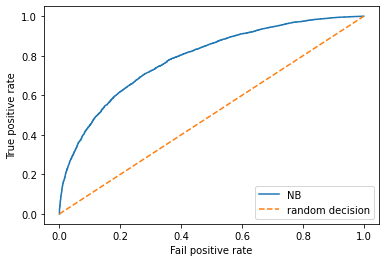

In [160]:
plt.plot(fpr_nb, tpr_nb, label='NB')
# plt.plot(fpr_logit, tpr_logit, label='logit')
plt.plot([0, 1], [0, 1], '--', label='random decision')
plt.xlabel('Fail positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [139]:
est = Pipeline([('vectorizer', TfidfVectorizer(min_df=50)), # min_df=50 because we're not interested in uncommon words
                ('classifier', MultinomialNB())])
est.fit(X_train,y_train)

vocab = est.get_params()['vectorizer'].vocabulary_ # A dictionary of (word, value) pairs
                                                   # vocab['word'] is the index in the coefficient array corresponding to 'word'
    
coeff_pos = est.get_params()['classifier'].feature_log_prob_[1] 
coeff_neg = est.get_params()['classifier'].feature_log_prob_[0]

In [143]:
from numpy import argsort

polarity = coeff_pos - coeff_neg
indices = argsort(polarity) # indices of the polarity list, sorted from least to greatest

pos_words = open("pos_words.txt","w+")

print("Saved Positive Words \n-----")
for word in vocab:
    if vocab[word] in indices[-60:]:
        pos_words.write(word + " ")
pos_words.close()
negative_words = open("negative_words.txt","w")
print("\n Saved Negative Words \n-----")
for word in vocab:
    if vocab[word] in indices[:60]:
        negative_words.write(word + " ") 
        
pos_words.close()

Saved Positive Words 
-----

 Saved Negative Words 
-----


In [159]:
def draw_wordcloud(text, max_words, max_font_size, figure_size, title, title_size, color):
#     cmp = cm.get_cmap(str(color), 8)
    wordcloud = WordCloud(max_words=max_words, background_color="white", 
                          colormap = color, max_font_size=max_font_size).generate(text)

    # Display the generated image:
    plt.figure(figsize= figure_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontdict={'size' : title_size, 'color': 'black'})
    plt.axis("off")
    plt.show()

In [160]:
text = open("pos_words.txt","r")
positive_text = text.readlines()

In [180]:
pos_color = cm.get_cmap('viridis', 8)
neg_color = cm.get_cmap('hot', 8)

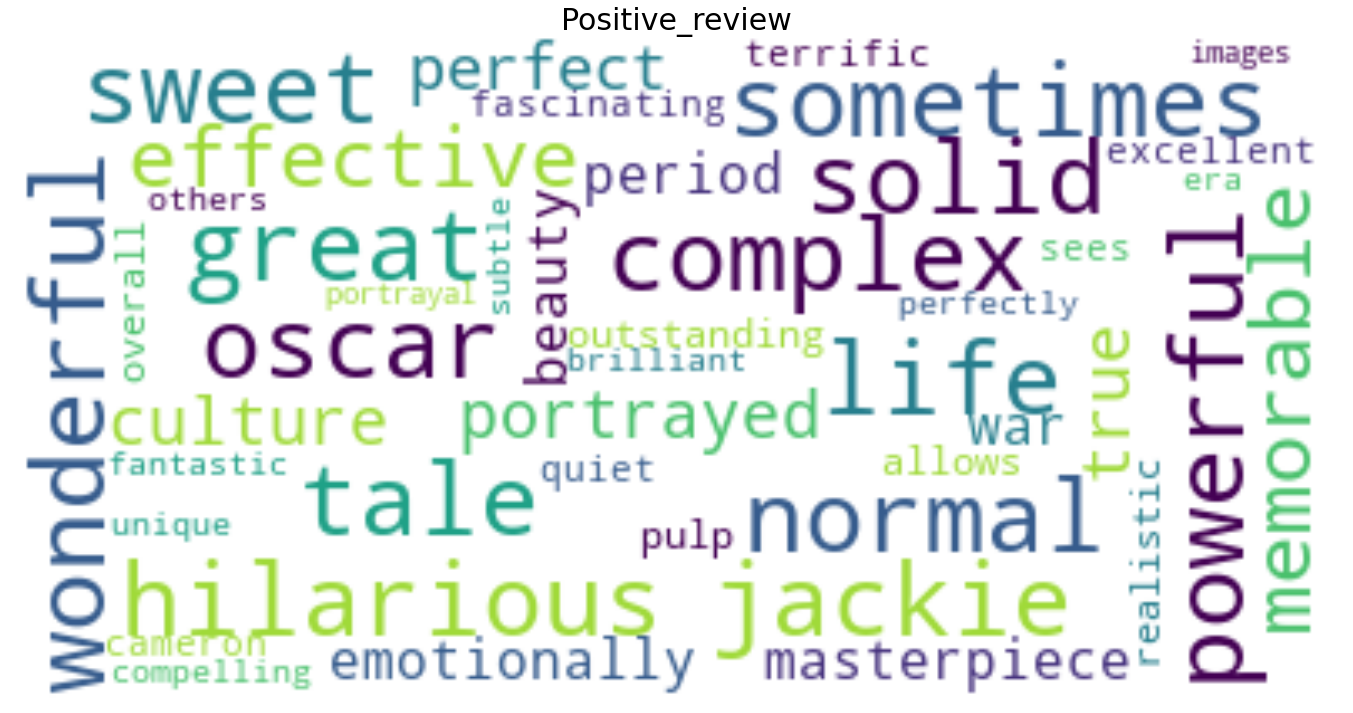

In [181]:
draw_wordcloud(positive_text[0], 45, 30, [24,16], "Positive_review", 30,pos_color)

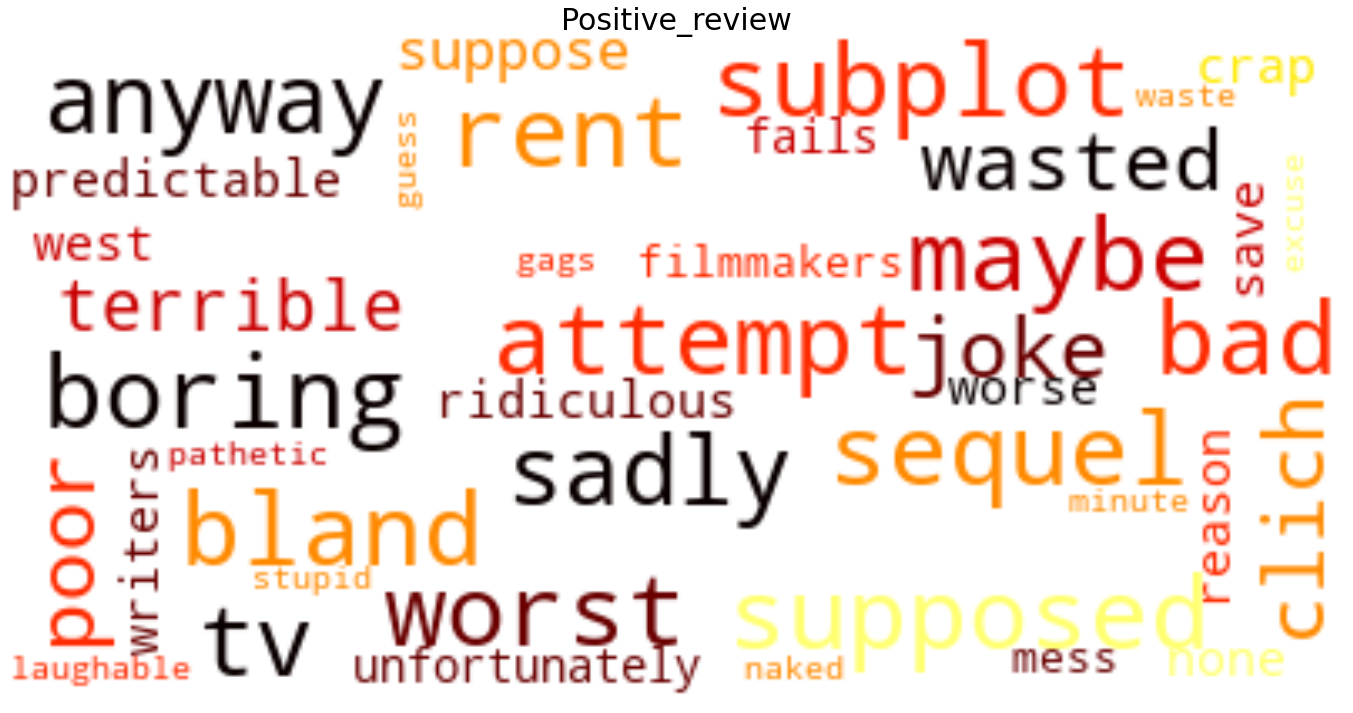

In [182]:
text = open("negative_words.txt","r")
words = text.readlines()
draw_wordcloud(words[0], 45, 30, [24,16], "Positive_review", 30, neg_color)